# Clusterization of music listening habits


#### Mission

We are given the Last.FM account of a user with the request of recommending them new songs.

#### Resources used

- The Last.FM API will be used to gather information regarding the user's listening history.
- The Spotify API for feature extraction of aggregated tracks.
- Scikit-learn modules for clusterization.

![Structure of the project](projectstructure.png)

#### Table of contents
1. Data Aggregation and Preprocessing
- 1.1. Last.FM track extraction
- 1.2. Spotify track feature extraction
- 1.3. Feature visualization
2. Model Training
- 2.1. Choice of clustering algorithms
- 2.2. K-Means
- 2.3. Gaussian Mixtures
3. Model Integration Discussion and Future Work
***

## 1. Data Aggregation and Preprocessing

In order for model training and clusterization to take place, data sources as well as feature engineering methodology needs to be set in place.

In this situation we are given a public user profile. Last.FM is a music themed social network that tracks the user's listening habits through various extensions. The history of user's scrobbles is exposed through an official API endpoint and, as such, an API call strategy will be employed in place of classic web scraping.

Once a list of the user's listened track is readily available, development of feature sets corresponding to each song must follow. Spotify offers such valuable information through their audio feature API endpoint.


### 1.1. Last.FM track extraction

This section will output an array of tracks under the exact form that is returned by the API.

In [1]:
import json
import requests

with open('keys.txt') as secret_file:
    keys = json.load(secret_file)
    
# Last.FM api information
lfm_api_key = keys["lfm_api_key"]
lfm_shared_secret = keys["lfm_shared_secret"]
lfm_api_base = "http://ws.audioscrobbler.com/2.0/"

headers = {
    'User-Agent': 'user Soutaisei ML project',
    'Authorization': 'Bearer {0}'.format(lfm_api_key)
}

All unique tracks from the user's profile are extracted if their playcount exceeds a given number.

In [2]:
import time

def getTopTracks(req_playcount):
    api_url = lfm_api_base + '?method=user.gettoptracks&user=Noppoly&api_key=' + lfm_api_key + '&format=json'
    
    current_page = 1
    extracted_tracks = []
    
    print("Beginning extraction...")
    while True:
        params = {
            'period': 'overall',
            'page': current_page
        }
        
        response = requests.get(api_url, params=params, headers=headers)

        if response.status_code == 200:
            decoded_response = json.loads(response.content.decode('utf-8'))
            
            for track in decoded_response['toptracks']['track']:
                playcount = int(track['playcount'])
                if playcount < req_playcount:
                    print("Identified tracks no longer have over {} plays.".format(req_playcount))
                    print("Stopping at {} extracted tracks.".format(len(extracted_tracks)))
                    return extracted_tracks
                
                extracted_tracks.append(track)
        
        current_page += 1
        if current_page % 15 == 0:
            print("Advancing to page no. {} with {} extracted.".format(current_page, len(extracted_tracks)))
            
        time.sleep(2)
    
    
lfm_tracks = getTopTracks(req_playcount=10)

Beginning extraction...
Advancing to page no. 15 with 700 extracted.
Advancing to page no. 30 with 1450 extracted.
Advancing to page no. 45 with 2200 extracted.
Advancing to page no. 60 with 2950 extracted.
Identified tracks no longer have over 10 plays.
Stopping at 3656 extracted tracks.


### 1.2. Spotify trackfeature extraction

After gathering all the track objects, features are extracted using the Spotify audio feature endpoint. An overview of features that will take part in the clustering process:

- __acousticness__
- __danceability__
- __energy__, measuring the intensity of a track (loud & noisy vs. ambiental)
- __instrumentalness__
- __liveness__
- __loudness__
- __speechiness__, where higher values equate to a higher presence of spoken words in a track (rap vs. instrumental)
- __valence__, describing whether the track is happy or sad on a scale
- __tempo__

More insight on each one of them here:
https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

***
#### API access and authorization

In [3]:
import base64

sp_client_id = keys["sp_client_id"]
sp_client_secret = keys["sp_client_secret"]

sp_base_url = ''

def getSpotifyAuthorizationURL():
    params = {
        'client_id': sp_client_id,
        'response_type': 'code',
        'redirect_uri': 'https://github.com/vrctin'
    }
    
    response = requests.get('https://accounts.spotify.com/authorize', params=params)
    return response.url

getSpotifyAuthorizationURL()

'https://accounts.spotify.com/login?continue=https%3A%2F%2Faccounts.spotify.com%2Fauthorize%3Fclient_id%3Dd155280dad834c76a20fbec412090a9a%26response_type%3Dcode%26redirect_uri%3Dhttps%253A%252F%252Fgithub.com%252Fvrctin'

In [4]:
# Replace with the callback from earlier
sp_code = "AQCTPXxuAUZAmFWmUNLL1of2NrH34GwzCcoGNFsH7jWbx1l9PcK_2-xL9nSrDxfBDlGux7n2ap5o5oV6KOwR0n2rWXLy4RFppGGBWMOKH0qJhIBrRzTYFTh9UhBw1yqmjqP8jQBY17Y7XTlQm9lSZRNEsuxuZrLUcAA2hvw"

def getSpotifyTokens():
    data = {
        'grant_type': 'authorization_code',
        'code': sp_code,
        'redirect_uri': 'https://github.com/vrctin',
        'client_id': sp_client_id,
        'client_secret': sp_client_secret
    }
    
    response = requests.post("https://accounts.spotify.com/api/token", data=data)
    decoded_response = json.loads(response.content.decode('utf-8'))
    return decoded_response['access_token'], decoded_response['refresh_token']

sp_access, sp_refresh = getSpotifyTokens()

In [20]:
def refreshAccessToken(refresh_token):
    api_url = "https://accounts.spotify.com/api/token"
    
    params = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token,
        'client_id': sp_client_id,
        'client_secret': sp_client_secret
    }
    
    joined_client = "{}:{}".format(sp_client_id, sp_client_secret)

    
    response = requests.post(api_url, data=params)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response['access_token']

sp_access = refreshAccessToken(sp_refresh)

***
#### Obtaining track IDs

Features of a Last.FM extracted track can only be obtain once we identify it within Spotify's database.

As such, a Spotify search endpoint is called for each track the user has listened to. Simple search term strings are built using the returned objects from the earlier section. 

Only the first search result is taken into account.

In [6]:
search_terms = []
for track in lfm_tracks:
    artist_name = track['artist']['name']
    song_name = track['name']
    
    search_term = '{} - {}'.format(artist_name, song_name).lower()
    search_terms.append(search_term)

In [7]:
sp_api_base = "https://api.spotify.com/v1"

def searchSpotifySong(query):
    api_url = sp_api_base + "/search"
    
    params = {
        'q': query,
        'type': 'track',
        'limit': 1
    }
    
    headers = {
        'Authorization': 'Bearer ' + sp_access
    }
    response = requests.get(api_url, params=params, headers=headers)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response

Given the obscure nature of the user's music taste, many of the songs they listen to may unfortunately not show up on Spotify.

In [8]:
track_ids = []

print("Beginning search...")

failed_items = 0
for term in search_terms:
    try:
        search_result = searchSpotifySong(term)
        time.sleep(0.3)

        track_id = search_result['tracks']['items'][0]['id']
        if track_id not in track_ids:
            track_ids.append(track_id)

        if len(track_ids) % 400 == 0:
            print("Reached {} milestone. {} failed.".format(len(track_ids), failed_items))
    except:
        failed_items += 1
    

print("Extracted {} ids.\nCould not identify {} songs.".format(len(track_ids), failed_items))

Beginning search...
Reached 400 milestone. 158 failed.
Reached 800 milestone. 389 failed.
Reached 1200 milestone. 657 failed.
Reached 1600 milestone. 918 failed.
Reached 2000 milestone. 1301 failed.
Extracted 2131 ids.
Could not identify 1456 songs.


***
#### Extracting features

The Spotify API allows us to extract 100 audio features per call maximum.

We split the tracks we have into chunks and call the API accordingly.

In [9]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

track_id_chunks = list(chunks(track_ids, 100))

def getMultipleAudioFeatures(track_ids):
    api_url= "https://api.spotify.com/v1/audio-features"
    
    params = {
        'ids': ','.join(track_ids),
    }
    
    headers = {
        'Authorization': 'Bearer ' + sp_access
    }
    response = requests.get(api_url, params=params, headers=headers)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response

audio_features = []
for chunk in track_id_chunks:
    chunk_features = getMultipleAudioFeatures(chunk)['audio_features']
    audio_features.append(chunk_features)
    
    time.sleep(2)

print("Extracted features for {} songs through {} chunks.".format(len(track_ids), len(track_id_chunks)))

Extracted features for 2131 songs through 22 chunks.


The resulting array is flattened and unnecessary information is removed from the response.

In [10]:
import numpy as np
import pandas as pd

audio_features_flat = np.concatenate(audio_features)

for feature in audio_features_flat:
    del feature['key']
    del feature['mode']
    del feature['type']
    del feature['id']
    del feature['uri']
    del feature['track_href']
    del feature['analysis_url']
    del feature['duration_ms']
    del feature['time_signature']

audio_features_dataframe = pd.DataFrame.from_records(audio_features_flat)
audio_features_dataframe.head(1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.458,0.309,-14.186,0.0283,0.909,0.956,0.118,0.0555,106.004


One further preprocessing requirement is to scale the loudness and tempo values from 0 to 1.

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

cols_to_scale = ['loudness', 'tempo']
audio_features_dataframe[cols_to_scale] = scaler.fit_transform(audio_features_dataframe[cols_to_scale])
audio_features_dataframe.head(1)

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.458,0.309,0.648937,0.0283,0.909,0.956,0.118,0.0555,0.479413


### 1.3. Feature visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FDA2E88D30>,
      dtype=object)

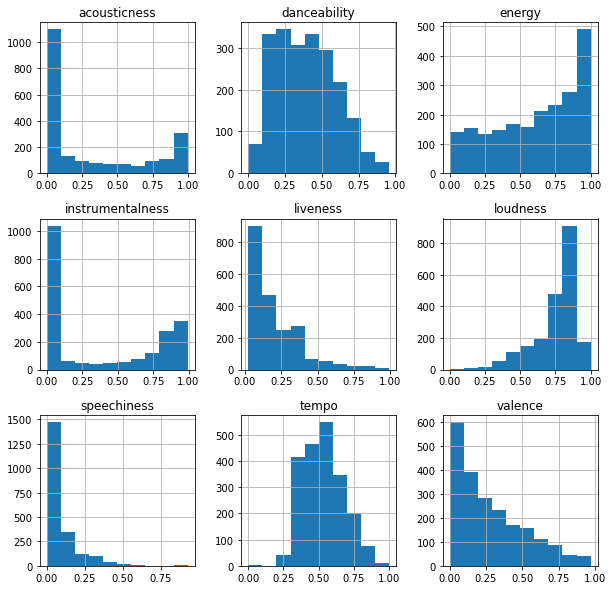

In [29]:
audio_features_dataframe.hist(figsize=(10,10))

#### Observations

The user's specific track selection is polarized on the following dimensions: acousticness, energy and instrumentalness.
It is expected that those will play a key role in the separation of clusters.

## 2. Model Training

### 2.1. Choice of clustering algorithms

Clusterization will be done through K-Means and Gaussian Mixtures. Models will be trained multiple times over varying amounts of clusters and performance will be evaluated through specific model parameters.

A suitable model will be chosen based on the user's feedback.

### 2.2. K-Means

#### Training

In [12]:
from sklearn.cluster import KMeans

inertias = []

cols_to_drop = []
adjusted_audio_features = audio_features_dataframe.drop(columns=cols_to_drop)
for n_clusters in range(2, 10):
    print("Training with {} clusters...".format(n_clusters))
    kmodel = KMeans(n_clusters=n_clusters, random_state=47).fit(adjusted_audio_features)
    inertias.append(kmodel.inertia_)

print("Training concluded")

Training with 2 clusters...
Training with 3 clusters...
Training with 4 clusters...
Training with 5 clusters...
Training with 6 clusters...
Training with 7 clusters...
Training with 8 clusters...
Training with 9 clusters...
Training concluded


#### Performance

Performance is evaluated based on intertia and silhouette score.

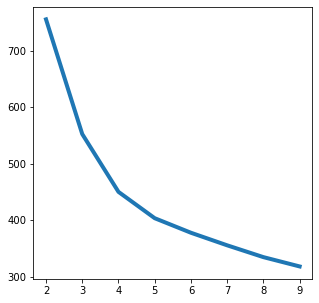

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 5)

y = range(2, 10)
plt.plot(y, inertias, linewidth=4, label="Model inertia")

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score

for n_clusters in range(2, 10):
    print("Training with {} clusters...".format(n_clusters))
    kmodel = KMeans(n_clusters=n_clusters, random_state=7)
    kmodel_labels = kmodel.fit_predict(audio_features_dataframe)
    
    silhouette_avg = silhouette_score(audio_features_dataframe, kmodel_labels)
    print("Silhouette average for {} clusters: {}".format(n_clusters, silhouette_avg))
        

Training with 2 clusters...
Silhouette average for 2 clusters: 0.36933259269289975
Training with 3 clusters...
Silhouette average for 3 clusters: 0.3414450484230155
Training with 4 clusters...
Silhouette average for 4 clusters: 0.35360273156679445
Training with 5 clusters...
Silhouette average for 5 clusters: 0.2868070325277493
Training with 6 clusters...
Silhouette average for 6 clusters: 0.2641585415754239
Training with 7 clusters...
Silhouette average for 7 clusters: 0.2654371613762383
Training with 8 clusters...
Silhouette average for 8 clusters: 0.2511115378211421
Training with 9 clusters...
Silhouette average for 9 clusters: 0.24821317218414374


The elbow method as well as the silhouette score point towards a number of 4 clusters. This option will be explored further.

***
#### Average feature values for 4 clusters

In [46]:
kmodel = KMeans(n_clusters=4, random_state=7).fit(audio_features_dataframe)
predictions = kmodel.predict(audio_features_dataframe)

audio_features_4cl = audio_features_dataframe.copy()
audio_features_4cl['km_cluster'] = predictions

clusters = audio_features_4cl.groupby('km_cluster').agg('mean')
clusters

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
km_cluster,,,,,,,,,
0,0.331345,0.760114,0.810525,0.087784,0.067627,0.776695,0.235013,0.227880,0.546482
1,0.462176,0.783664,0.840906,0.134933,0.085409,0.033125,0.249051,0.369678,0.556223
2,0.252159,0.208080,0.502773,0.045777,0.865018,0.884264,0.131339,0.106869,0.456431
3,0.483626,0.345915,0.680491,0.083848,0.729771,0.093359,0.174131,0.325812,0.515465


#### Cluster specifics:

Cluster 0
- high energy, loudness, instrumentalness
- low acousticness

Cluster 1
- high energy, loudness, notable speechiness and valence
- low acousticness, instrumentalness

Cluster 2
- high acousticness, instrumentalness
- low energy, danceability, loudness, valence

Cluster 3
- high danceability
- low energy, instrumentalness

#### Cluster assignment

The original dataframe's songs are assigned their respective clusters, for later visualization.

In [24]:
def getSpotifySongs(ids):
    api_url = "https://api.spotify.com/v1/tracks"
    
    params = {
        'ids': ','.join(ids),
    }
    
    headers = {
        'Authorization': 'Bearer ' + sp_access
    }
    response = requests.get(api_url, params=params, headers=headers)
    decoded_response = json.loads(response.content.decode('utf-8'))
    
    return decoded_response

songs_data = []
song_id_chunks = list(chunks(track_ids, 50))

print("Beginning lookup...")
for chunk in song_id_chunks:
    songs = getSpotifySongs(chunk)
    
    for song_info in songs['tracks']:
        
        artists = []
        for artist in song_info['artists']:
            artists.append(artist['name'])

        song_artists = ', '.join(artists)
        song_name = song_info['name']

        songs_data.append({
            'artist': song_artists,
            'title': song_name
        })

        if len(songs_data) % 400 == 0:
            print("Extracted {} songs...".format(len(songs_data)))
        
    time.sleep(1)

print("Done!")

Beginning lookup...
Extracted 400 songs...
Extracted 800 songs...
Extracted 1200 songs...
Extracted 1600 songs...
Extracted 2000 songs...
Done!


In [50]:
audio_features_4cl = pd.DataFrame.from_records(songs_data).join(audio_features_4cl)
audio_features_4cl.head(1)

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,km_cluster
0,Grouper,Heavy Water/I'd Rather Be Sleeping,0.458,0.309,0.648937,0.0283,0.909,0.956,0.118,0.0555,0.479413,2


#### Sampling the K-Means clusters

In [73]:
def getNSongsOfCluster(dataframe, n, cluster, model="km"):
    if model == "km":
        return dataframe[dataframe['km_cluster']==cluster].sample(n).drop(columns=["gm_cluster"])
    
    return dataframe[dataframe['gm_cluster']==cluster].sample(n).drop(columns=["km_cluster"])

clusters_samples = pd.DataFrame()

for i in range(0, 4):
    cluster_sample = getNSongsOfCluster(audio_features_4cl, 2, i)
    clusters_samples = pd.concat([clusters_samples, cluster_sample], axis=0)
    
clusters_samples

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,km_cluster
1820,HEALTH,Heaven,0.383,0.647,0.783343,0.0707,0.001450,0.7650,0.2940,0.1530,0.552023,0
1922,Alvvays,Lollipop (Ode to Jim),0.293,0.957,0.900106,0.0733,0.000102,0.4850,0.3300,0.3880,0.750886,0
646,Adult Mom,What's Another Lipstick Mark,0.600,0.518,0.761729,0.0261,0.156000,0.5240,0.0854,0.9600,0.365304,1
1866,Nirvana,Even In His Youth - B-Side,0.443,0.975,0.886315,0.0751,0.000042,0.0106,0.3580,0.3300,0.645659,1
1830,Julianna Barwick,Anjos,0.127,0.273,0.611371,0.0351,0.925000,0.9850,0.0794,0.1510,0.294769,2
1555,"Melodious Blissful Healing Therapies, Mindful ...",Got A Clarity - Original Mix,0.169,0.102,0.476142,0.0721,0.993000,0.8230,0.1150,0.0844,0.304597,2
1409,Mount Eerie,Through the Trees Pt. 2,0.370,0.285,0.605944,0.0339,0.786000,0.1780,0.0927,0.1040,0.569404,3
75,Nick Drake,Pink Moon,0.638,0.256,0.613838,0.0492,0.819000,0.0707,0.1450,0.4380,0.373019,3


### 2.3. Gaussian Mixtures

An alternative method we'll be exploring. 

#### Training

In [42]:
from sklearn.mixture import GaussianMixture

aics = []
bics = []
for i in range(1, 10):
    gm = GaussianMixture(n_components=i, n_init=10).fit(audio_features_dataframe)
    bics.append(gm.bic(audio_features_dataframe))
    aics.append(gm.aic(audio_features_dataframe))
    
    print("Trained with {} clusters...".format(i))

Trained with 1 clusters...
Trained with 2 clusters...
Trained with 3 clusters...
Trained with 4 clusters...
Trained with 5 clusters...
Trained with 6 clusters...
Trained with 7 clusters...
Trained with 8 clusters...
Trained with 9 clusters...


#### Performance


Akaike and Bayesian information criterions are used to evaluate the performance of the Gaussian Mixture.

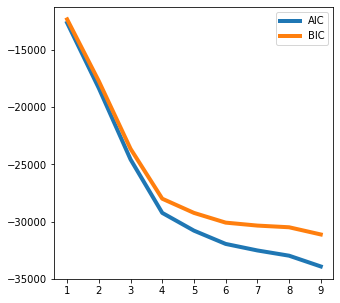

In [44]:
y = range(1, 10)
plt.plot(y, aics, linewidth=4, label="AIC")
plt.plot(y, bics, linewidth=4, label="BIC")
plt.legend()
plt.show()

A number of 4 clusters seems to be ideal.

#### Cluster assignment

A new column is appended to the original dataframe for ease of visual comparison of the two proposed models.

In [71]:
gmmodel = GaussianMixture(n_components=4, n_init=10).fit(audio_features_dataframe)
predictions = gmmodel.predict(audio_features_dataframe)

audio_features_4cl['gm_cluster'] = predictions
audio_features_4cl.sample(5)

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,km_cluster,gm_cluster
1584,Wristmeetrazor,Xoxo (Love Letter from a Loaded Gun),0.338,0.958,0.879713,0.0956,0.000006,0.800000,0.1130,0.272,0.723656,0,2
1311,Vein,A Crumpled Memo,0.200,0.987,0.917984,0.3170,0.000025,0.001160,0.3120,0.050,0.690139,1,1
1411,Nick Drake,From The Morning,0.639,0.166,0.529520,0.0446,0.864000,0.075200,0.1150,0.398,0.493989,3,3
249,"Bring Me The Horizon, Josh Scogin",The Fox and the Wolf (feat. Josh Scogin),0.151,0.896,0.872336,0.0798,0.000407,0.000020,0.7360,0.203,0.686001,1,2
815,America,Sister Golden Hair,0.420,0.696,0.805521,0.0323,0.158000,0.000086,0.0951,0.726,0.615041,1,1


#### Cluster feature averages

In [65]:
clusters = audio_features_4cl.groupby('gm_cluster').agg('mean').drop(columns=['km_cluster'])
clusters

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
gm_cluster,,,,,,,,,
0,0.447302,0.543777,0.732582,0.078324,0.410765,0.402102,0.213348,0.328173,0.535879
1,0.524992,0.655616,0.807279,0.152573,0.252749,0.000367,0.226621,0.412529,0.537948
2,0.224304,0.238955,0.528070,0.040680,0.744113,0.881451,0.122107,0.072254,0.469492
3,0.315308,0.874821,0.848831,0.099486,0.000545,0.455589,0.260899,0.229810,0.556665


A notable difference between the two models is showcased through the average valence value of cluster no. 2.

While K Means clustered songs in very contrasting groups, Gaussian Mixtures seems to have profiled tracks in a way that allows for intersection across all features.

This may be a consequence of circular clustering vs. covariances/means.

#### Sampling the Gaussian Mixture clusters

In [74]:
clusters_samples = pd.DataFrame()

for i in range(0, 4):
    cluster_sample = getNSongsOfCluster(audio_features_4cl, 2, i, model="gm")
    clusters_samples = pd.concat([clusters_samples, cluster_sample], axis=0)
    
clusters_samples

,artist,title,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,gm_cluster
1813,Godspeed You! Black Emperor,"Anthem for No State, Pt. III",0.0986,0.710,0.822577,0.0502,0.029100,0.790000,0.143,0.0705,0.721196,0
1029,"William Basinski, Lawrence English",Mono No Aware 1.1,0.1590,0.122,0.274004,0.0457,0.840000,0.876000,0.335,0.0369,0.605652,0
113,100 gecs,dog food,0.5580,0.406,0.769036,0.4870,0.138000,0.000036,0.120,0.1410,0.764382,1
483,The Avalanches,Frontier Psychiatrist,0.7000,0.901,0.807424,0.2640,0.123000,0.000092,0.388,0.4220,0.447235,1
414,Duster,Earth Moon Transit,0.3510,0.887,0.847457,0.0316,0.000021,0.746000,0.169,0.2630,0.462960,2
850,SeeYouSpaceCowboy...,Absolutely Absolute Absolution,0.2390,0.934,0.831434,0.1500,0.000067,0.006650,0.292,0.2830,0.654872,2
1455,Alvvays,Plimsoll Punks,0.2840,0.854,0.877787,0.0453,0.008000,0.021800,0.277,0.3620,0.735193,3
903,Sufjan Stevens,The Predatory Wasp of The Palisades Is Out To ...,0.4700,0.420,0.726536,0.0366,0.919000,0.036800,0.111,0.3090,0.692554,3


## 3. Model Integration Discussion and Future Work

User has reported the Gaussian Mixture model to group up songs more effectively in terms of what mood each cluster represents to them.

#### Example of clustering differences

In [81]:
audio_features_4cl.sample(8).drop(columns=audio_features_4cl.columns[[2, 3, 4, 5, 6, 7, 8, 9, 10]])

,artist,title,km_cluster,gm_cluster
515,"Chihei Hatakeyama, Hakobune",Vibrant color,2,0
1063,HEALTH,FEEL NOTHING,1,2
1476,Death Grips,Bass Rattle Stars Out The Sky,1,1
1606,Brand New,Lit Me Up,3,3
260,Death Grips,Giving Bad People Good Ideas,1,1
1500,Hollerado,Fake Drugs,1,1
1945,Chad VanGaalen,Peace on the Rise,2,0
1201,The I.L.Y's,Articulate (Im Going so Far into You),1,1


#### Recommender system solution

Featured playlists may be periodically acquired through the Spotify API. The component songs may then be clustered and recommended to the user depending on their input mood.

The selection of songs extracted from said playlists may be restricted through a machine learning model that classifies which tracks the user is sure to enjoy.

#### Integration

The resulting suggestions may take the form of a newsletter email. 

In the case where the Gaussian Mixture is deployed on the web, the user may demand any amount of tracks to be filtered into specific clusters that match their state of mind at that specific moment.